In [164]:
# %%writefile Ind_CMO.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import Ind_Model_Base

import numpy as np
import pandas as pd

import QUANTAXIS as QA

import matplotlib.pyplot as plt


import Analysis_Funs as af

import talib
import base.JuUnits as ju

# %load_ext autoreload
# %autoreload 2
# %aimport Analysis_Funs,Ind_Model_Base


class SO(Ind_Model_Base.Ind_Model):
    """随机振荡器 (Stochastic Oscillator)
       市场依赖，单因子不算优秀
    """
    optimum_param={'valid':True, 'main':'feature_SO_CONTINUITY_NEG_ABS', 'desition_direct':1, 'freq':'d','neutralize':{'enable':False,'static_mv':False}}
    
    def __init__(self,data, frequence=QA.FREQUENCE.DAY):
        super().__init__(data, 'SO', frequence)
        
        ### 正式使用时由实例设置为true来加速
#         self.set_ignore_sub_ind(False)
        

    def on_set_params_default(self):
        return {'timeperiod':20}
    
        
    def on_indicator_structuring(self, data):
        return self.excute_for_multicode(data, self.kernel, **self.pramas)
    
    def on_desition_structuring(self, data, ind_data):
        """
        """
        def feature(item_df):
            direct = np.sign(item_df['K'] - item_df['D'])
            return -1 * np.abs( af.timeline_event_continuity(direct.fillna(0)) )
#             return af.timeline_event_continuity(direct.fillna(0))

        event_continuity = self.excute_for_multicode(self.ind_df,
                                         lambda x: pd.DataFrame(feature(x),
                                         index=x.index,
                                         columns=['feature_SO_CONTINUITY_NEG_ABS']))
        # NEG_ABS时防止0干扰
        event_continuity[event_continuity==0] = np.nan
        self.ind_df = pd.concat([self.ind_df, event_continuity],axis=1)
        return event_continuity
        
    def kernel(self,dataframe, timeperiod):
#         %K = (CLOSE - MIN (LOW (%K))) / (MAX (HIGH (%K)) - MIN (LOW (%K))) * 100 
#         %D = SMA (%K, N) 
        if len(dataframe)<=timeperiod:
            return None
        
        close = dataframe.close
        low = dataframe.low.rolling(timeperiod).min()
        high = dataframe.high.rolling(timeperiod).max()
        k = (close - low)/(high - low)
        k.name = 'K'
        d = talib.MA(k, timeperiod)
        d.name = 'D'
        
        df = pd.concat([k,d], axis=1)
        return df

    def plot(self):
        if self.fast_mode:
            raise 'fast_mode is True,cant draw chart'
        
        


In [157]:
%%time
# data = smpl.get_data(['000001'],end='2019-11-29',gap=250).data
# close = data.close
low = data.low.rolling(20).min()
high = data.high.rolling(20).max()


k = (close - low)/(high - low)
d = talib.MA(k, 20)
d


Wall time: 1e+03 µs


date        code  
2018-11-20  000001         NaN
2018-11-21  000001         NaN
2018-11-22  000001         NaN
2018-11-23  000001         NaN
2018-11-26  000001         NaN
                        ...   
2019-11-25  000001    0.347561
2019-11-26  000001    0.315209
2019-11-27  000001    0.295978
2019-11-28  000001    0.281422
2019-11-29  000001    0.252082
Length: 251, dtype: float64

In [20]:
%%time
import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)
import tools.Sample_Tools as smpl
import Analysis_Funs as af
import base.JuUnits as ju
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib
data = smpl.get_data(['000001'],end='2019-11-29',gap=504).data

so =SO(data)
so.fit()
pd.concat([data.close,so.ind_df['K'],so.ind_df['D']],axis=1).plot(secondary_y=['K','D'],figsize=(1620/72,420/72))
plt.grid()
# rvi.ind_df

# diff = data.close[0:10]
# np.where(np.sign(diff)>=0,diff,0)

Wall time: 51 ms


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2021-11-28


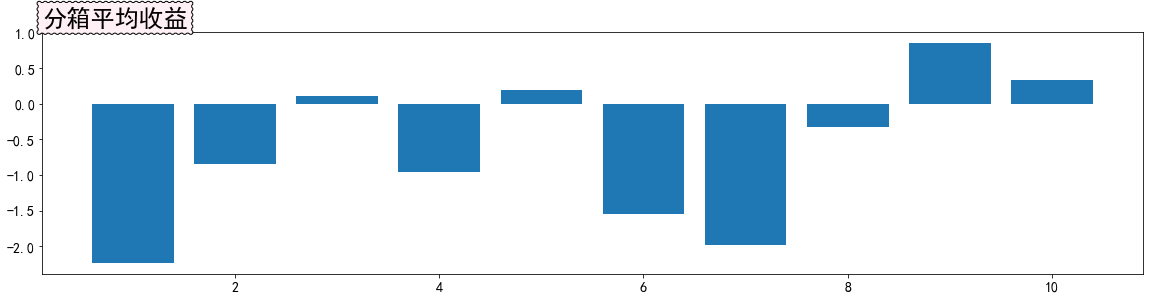

2020-11-28


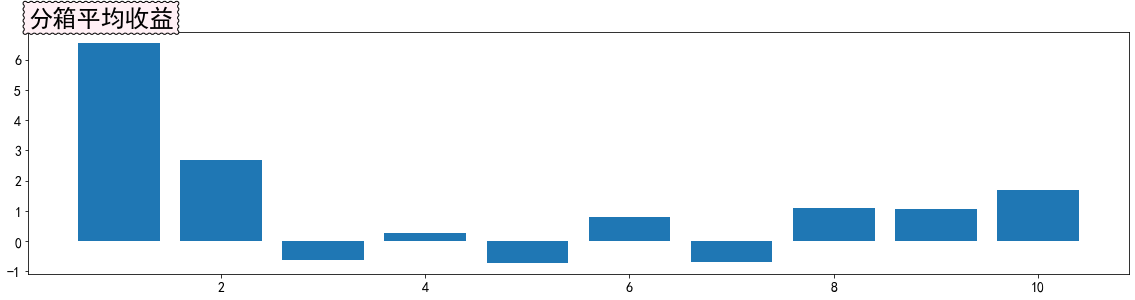

2019-11-28


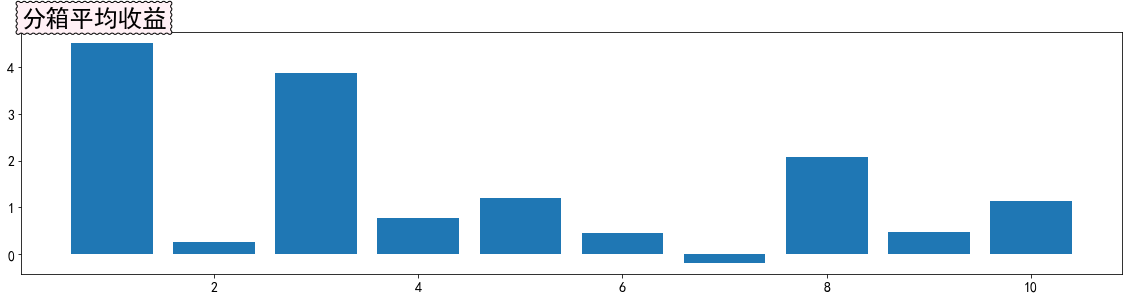

2018-11-28


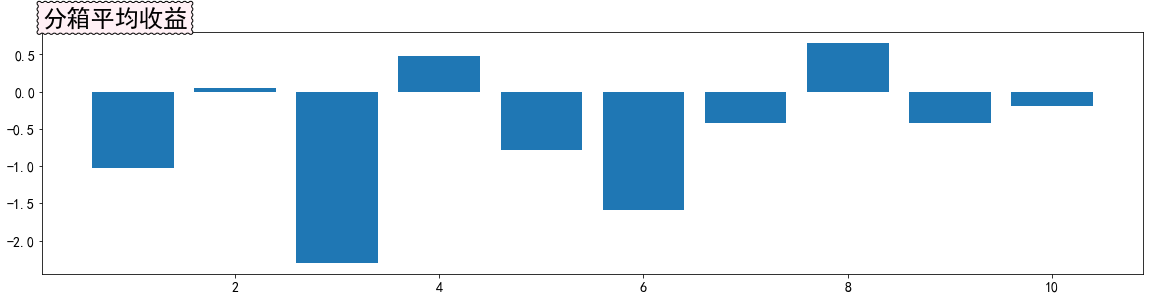

2017-11-28


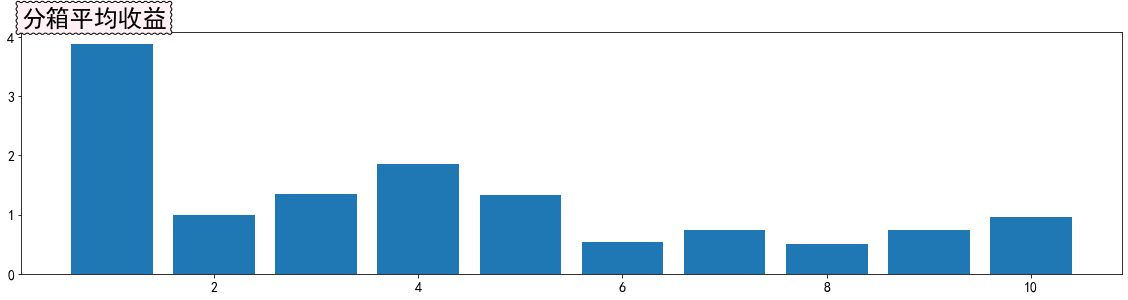

2016-11-28


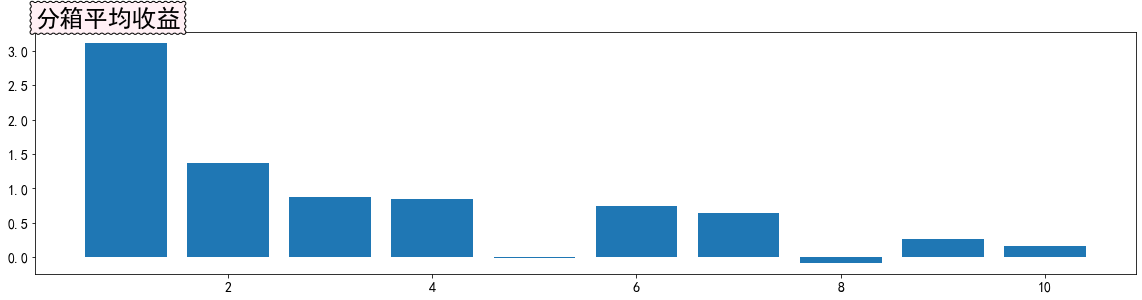

Wall time: 18.2 s


In [168]:
%%time
from tools.Test_Tools import FactorTest

%load_ext autoreload
%autoreload 1
%aimport tools.Test_Tools

dates = ['2021-11-28','2020-11-28','2019-11-28','2018-11-28','2017-11-28','2016-11-28']
# dates = ['2021-11-28']
for date in dates:
    print(date)
    test = FactorTest(SO, sample='上证50', freq="d",end=date, gap=250, only_main=True, neutralize={'enable':False,'static_mv':False},target_field='feature_SO_CONTINUITY_NEG_ABS')
    test.process()
    test.plot(only_binned=True)


2020-11-28


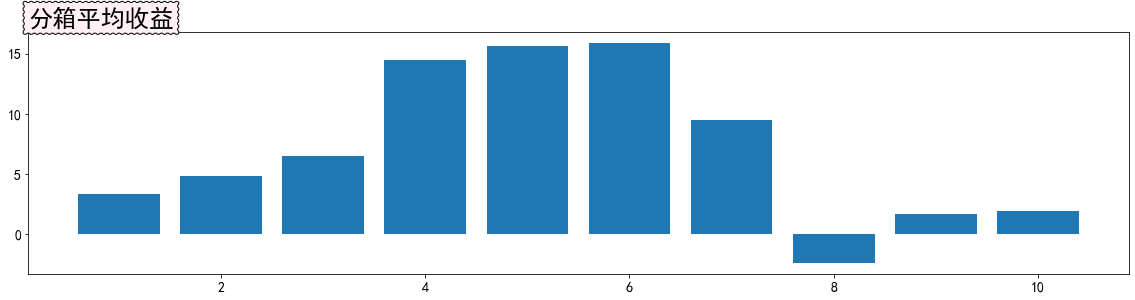

In [105]:
# dates = ['2021-11-28','2020-11-28','2019-11-28','2018-11-28','2017-11-28','2016-11-28']
dates = ['2020-11-28']
for date in dates:
    print(date)
    test = FactorTest(SO, sample='沪深300', freq="d",end=date, gap=250, only_main=True, neutralize={'enable':False,'static_mv':False},target_field='feature_SO_CONTINUITY_NEG_ABS')
    test.process()
    test.plot(only_binned=True)

In [78]:
print(test.ind_ret_df.loc[(slice(None),'000001'),'feature_SO_CONTINUITY_NEG_ABS'].values.tolist())

[-99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1, 1, 2, 3, 4, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, 1, -1, 1, -1, 1, 2, -1, -2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1, -2, -3, -4, -5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, -1, -2, 1, 2, 3, -1, -2, -3, -4, -5, 1, -1, 1, 2, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, 1, -1, -2, -3, 1, -1, -2, 1, 2, -1, -2, -3, -4, -5, 1, 2, 3, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1, -2, -3, -4, -5, -6, -7, -8, 1, 2, 3, 4, 5, 6, 7, 8, -1, -2, -3, -4, -5, -6, -7, -8, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18]
